### Model 2: Sentiment Analysis : RoBERTa

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, TFRobertaModel

# Load dataset
df = pd.read_csv("BA_Airline_Reviews_Preprocessed.csv")
df = df.dropna(subset=["ReviewBody", "Recommended"])
df["Recommended"] = df["Recommended"].astype(int)

# Identify numerical and categorical features
numerical_cols = ["OverallRating", "SeatComfort", "CabinStaffService", "GroundService",
                  "ValueForMoney", "Food&Beverages", "InflightEntertainment"]

# Check class distribution and compute class weights
class_counts = df["Recommended"].value_counts()
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(df["Recommended"]), y=df["Recommended"])
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Distribution:", class_counts)
print("Class Weights:", class_weight_dict)

# Stratified train-test split
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    df["ReviewBody"], df[numerical_cols], df["Recommended"], test_size=0.2, stratify=df["Recommended"], random_state=42)

# Load RoBERTa tokenizer and model
MODEL_NAME = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
roberta_model.trainable = False  # Freeze RoBERTa layers

# Tokenize text
def tokenize_text(text_series, tokenizer, max_length=128):
    return tokenizer(
        text_series.tolist(),
        max_length=max_length,
        truncation=True,
        padding="max_length",
        return_tensors="tf"
    )

X_train_tokens = tokenize_text(X_train_text, tokenizer)
X_test_tokens = tokenize_text(X_test_text, tokenizer)

# Build the multi-input RoBERTa-based model
def build_roberta_model():
    # Text Input (RoBERTa)
    input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="attention_mask")

    roberta_output = roberta_model(input_ids, attention_mask=attention_mask).last_hidden_state
    cls_token = tf.keras.layers.Lambda(lambda x: x[:, 0, :])(roberta_output)  # Extract `[CLS]`

    # Numerical Input
    num_input = tf.keras.layers.Input(shape=(X_train_num.shape[1],), dtype=tf.float32, name="num_input")
    num_dense = tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(num_input)

    # Concatenate RoBERTa output with structured data
    combined = tf.keras.layers.Concatenate()([cls_token, num_dense])
    print("Expected concatenated shape: 768 (CLS) + 7 (numerical) =", combined.shape[-1])

    combined = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(combined)
    combined = tf.keras.layers.Dropout(0.3)(combined)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(combined)  # Binary classification

    return tf.keras.Model(inputs=[input_ids, attention_mask, num_input], outputs=output)

# Compile the model
model = build_roberta_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Callbacks for early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    [X_train_tokens["input_ids"], X_train_tokens["attention_mask"], X_train_num],
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=([X_test_tokens["input_ids"], X_test_tokens["attention_mask"], X_test_num], y_test),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
y_pred = model.predict([X_test_tokens["input_ids"], X_test_tokens["attention_mask"], X_test_num])
y_pred_labels = np.round(y_pred)

# Print classification report
print(classification_report(y_test, y_pred_labels))

# Print model summary
print("\nFull Model Summary:")
model.summary()

# Print embedding and token info
embedding_shape = roberta_model.get_input_embeddings().weight.shape
print(f"\nWord Embeddings Shape: {embedding_shape}")
print(f"Vocabulary Size: {tokenizer.vocab_size}")

train_tokens = sum(len(t) for t in X_train_tokens["input_ids"].numpy())
test_tokens = sum(len(t) for t in X_test_tokens["input_ids"].numpy())
total_tokens = train_tokens + test_tokens
print(f"Total Tokens - Train: {train_tokens}, Test: {test_tokens}, Total: {total_tokens}")

max_len = max(len(tokenizer.tokenize(text)) for text in df["ReviewBody"])
avg_len = np.mean([len(tokenizer.tokenize(text)) for text in df["ReviewBody"]])
print(f"Max Tokenized Review Length: {max_len}")
print(f"Average Tokenized Review Length: {avg_len:.2f}")

# Extract intermediate outputs
intermediate_model = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer(index=-3).output)
intermediate_output = intermediate_model.predict([X_test_tokens["input_ids"], X_test_tokens["attention_mask"], X_test_num])
print("Intermediate concatenated output shape:", intermediate_output.shape)



Class Distribution: Recommended
0    2203
1    1498
Name: count, dtype: int64
Class Weights: {0: np.float64(0.8399909214707217), 1: np.float64(1.235313751668892)}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Expected concatenated shape: 768 (CLS) + 7 (numerical) = 800
Epoch 1/20
93/93 [==============================] - 24s 97ms/step - loss: 2.9954 - accuracy: 0.4584 - val_loss: 2.8241 - val_accuracy: 0.4575 - lr: 3.0000e-05
Epoch 2/20
93/93 [==============================] - 5s 56ms/step - loss: 2.7144 - accuracy: 0.5855 - val_loss: 2.5817 - val_accuracy: 0.7935 - lr: 3.0000e-05
Epoch 3/20
93/93 [==============================] - 5s 56ms/step - loss: 2.4920 - accuracy: 0.6824 - val_loss: 2.3777 - val_accuracy: 0.8219 - lr: 3.0000e-05
Epoch 4/20
93/93 [==============================] - 5s 56ms/step - loss: 2.3017 - accuracy: 0.7132 - val_loss: 2.1836 - val_accuracy: 0.8758 - lr: 3.0000e-05
Epoch 5/20
93/93 [==============================] - 5s 56ms/step - loss: 2.1126 - accuracy: 0.7959 - val_loss: 2.0091 - val_accuracy: 0.8893 - lr: 3.0000e-05
Epoch 6/20
93/93 [==============================] - 5s 56ms/step - loss: 1.9521 - accuracy: 0.8128 - val_loss: 1.8574 - val_accuracy: 0.8839 - lr: 3

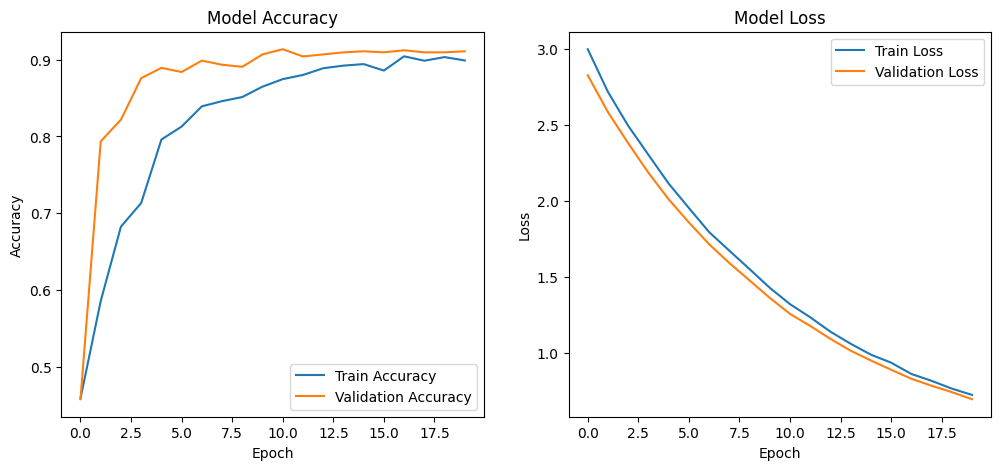

In [2]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.show()

plot_training_history(history)


In [3]:
intermediate_model = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer("concatenate").output)
intermediate_output = intermediate_model.predict([X_test_tokens["input_ids"], X_test_tokens["attention_mask"], X_test_num])
print("Expected raw concatenated output shape (CLS+numerical):", intermediate_output.shape)


24/24 [==============================] - 4s 38ms/step
Expected raw concatenated output shape (CLS+numerical): (741, 800)


In [4]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.output_shape)


0 input_ids [(None, 128)]
1 attention_mask [(None, 128)]
2 tf_roberta_model TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=(None, 128, 768), pooler_output=(None, 768), past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)
3 num_input [(None, 7)]
4 lambda (None, 768)
5 dense (None, 32)
6 concatenate (None, 800)
7 dense_1 (None, 128)
8 dropout_37 (None, 128)
9 dense_2 (None, 1)


# 🧠 Information:
You're not concatenating the raw 7 features.

You're concatenating the 32-dimensional vector learned from those 7 via a dense layer.

That’s why your concatenated shape becomes 800 and not 775.

# 💡 Why Use a Dense Layer on Numerical Features?
Using a Dense layer here is intentional and beneficial:

It lets the model learn better representations of raw features.

It's equivalent to learning a non-linear transformation or embedding of your structured data.

It also balances the scale mismatch between the large-dimensional BERT outputs and small numerical input.

In [6]:
import pandas as pd

# Extract model summary into a list
summary_lines = []
model.summary(print_fn=lambda x: summary_lines.append(x))

# Parse and clean summary
summary_data = []
for line in summary_lines[3:-4]:  # Skip headers and footers
    parts = [p for p in line.split(" ") if p]
    if len(parts) >= 5:
        layer_type = parts[0]
        output_shape = parts[1]
        param_count = parts[-2]
        summary_data.append((layer_type, output_shape, param_count))

# Create DataFrame for display
summary_df = pd.DataFrame(summary_data, columns=["Layer", "Output Shape", "Param #"])
print("\n📊 Cleaned Model Summary Table:\n")
display(summary_df.style.set_properties(**{
    'background-color': '#f9f9f9',
    'border-color': 'black',
    'border-style': 'solid',
    'color': 'black'
}).set_caption("Roberta + Numerical Model Architecture"))



📊 Cleaned Model Summary Table:



,Layer,Output Shape,Param #
0,input_ids,(InputLayer),0
1,attention_mask,(InputLayer,0
2,tf_roberta_model,(TFRobert,1246456
3,num_input,(InputLayer),0
4,lambda,(Lambda),0
5,dense,(Dense),256
6,concatenate,(Concatenate),0
7,dense_1,(Dense),102528
8,dropout_37,(Dropout),0
9,dense_2,(Dense),129


In [8]:
# Print model summary
print("\nFull Model Summary:")
model.summary()



Full Model Summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_ids[0][0]',           
 aModel)                     ngAndCrossAttentions(last_   32         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                  


📊 Classification Report:


,precision,recall,f1-score,support
0,0.977,0.871,0.921,441.000
1,0.836,0.970,0.898,300.000
accuracy,0.911,0.911,0.911,0.911
macro avg,0.907,0.920,0.910,741.000
weighted avg,0.920,0.911,0.912,741.000


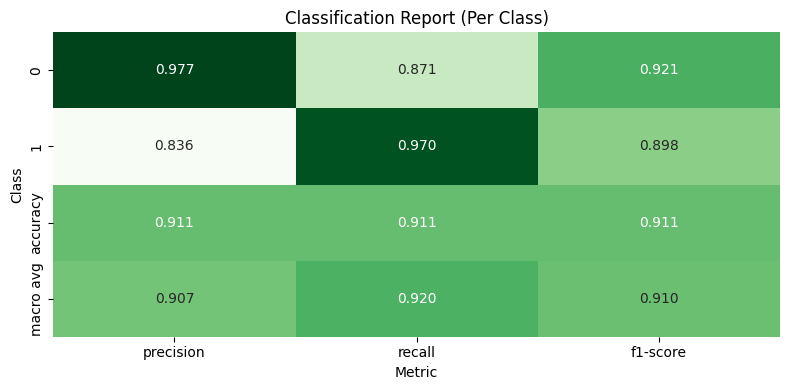

In [18]:
from sklearn.metrics import classification_report
import seaborn as sns

# Get detailed classification report as a dictionary
report_dict = classification_report(y_test, y_pred_labels, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Round values for readability
report_df = report_df.round(3)

# Display in table format
print("\n📊 Classification Report:")
display(report_df)

# Plot as a heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Greens", fmt=".3f", cbar=False)
plt.title("Classification Report (Per Class)")
plt.ylabel("Class")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()
